<a href="https://colab.research.google.com/github/GeorgeThan414/Machine_Learning_CSD/blob/main/Exercise8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import random

# Task 1 & 2 -load the data


#Task 2 - Unzip the data

In [2]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: dataset/Beagle/Beagle_1.jpg  
  inflating: dataset/Beagle/Beagle_10.jpg  
  inflating: dataset/Beagle/Beagle_100.jpg  
  inflating: dataset/Beagle/Beagle_11.jpg  
  inflating: dataset/Beagle/Beagle_12.jpg  
  inflating: dataset/Beagle/Beagle_13.jpg  
  inflating: dataset/Beagle/Beagle_14.jpg  
  inflating: dataset/Beagle/Beagle_15.jpg  
  inflating: dataset/Beagle/Beagle_16.jpg  
  inflating: dataset/Beagle/Beagle_17.jpg  
  inflating: dataset/Beagle/Beagle_18.jpg  
  inflating: dataset/Beagle/Beagle_19.jpg  
  inflating: dataset/Beagle/Beagle_2.jpg  
  inflating: dataset/Beagle/Beagle_20.jpg  
  inflating: dataset/Beagle/Beagle_21.jpg  
  inflating: dataset/Beagle/Beagle_22.jpg  
  inflating: dataset/Beagle/Beagle_23.jpg  
  inflating: dataset/Beagle/Beagle_24.jpg  
  inflating: dataset/Beagle/Beagle_25.jpg  
  inflating: dataset/Beagle/Beagle_26.jpg  
  inflating: dataset/Beagle/Beagle_27.jpg  
  inflating: dataset/Beagle/Beagle_28.jpg  
  

# Task 3 - Load the images as Numpy arrays

Bellow code,
transforms the classes from categorical to numerical from 0 to 9.

Then collect all the images and the corresponding labels, storing them in two lists X, y.

The shape of the images is desirable, through printing we can see the total length of the images, along with their height, width and the number of channels. In this case we want RGB sto the channels should be 3.


In [3]:
dataset_path='/content/dataset'
image_size=64

classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)

# Transform the categorical data to integer from 0-9
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
print(class_to_idx)

X=[]
y=[]

for cls in classes:
  cls_path=os.path.join(dataset_path, cls)
  label=class_to_idx[cls]

  for image_name in os.listdir(cls_path):
    image_path=os.path.join(cls_path, image_name)
    image=Image.open(image_path).convert("RGB")
    image=image.resize((image_size, image_size))
    image=np.array(image)

    X.append(image)
    y.append(label)

X=np.array(X)
y=np.array(y)
one_hot=OneHotEncoder(sparse_output=False)
Y=one_hot.fit_transform(y.reshape(-1,1))
print(f"Images shape: {X.shape}")   # [total_number_of images, height, width, channels]
print(f"Labels shape: {Y.shape}")

{'Beagle': 0, 'Boxer': 1, 'Bulldog': 2, 'Dachshund': 3, 'German_Shepherd': 4, 'Golden_Retriever': 5, 'Labrador_Retriever': 6, 'Poodle': 7, 'Rottweiler': 8, 'Yorkshire_Terrier': 9}
Images shape: (967, 64, 64, 3)
Labels shape: (967, 10)


# Task 4 & 5- MLP Implementation & Classification

The implementation of the model will take place using the torch framework. Specifically, for designing the model architecture, wrapt the data to dataset/dataloaders protocolls for accurate allignment between model architecture and data.

Bellow code depicts the MLP class, which consist of 3 linear layers, with Relu as activation function which injects aslo the non-linearity in the architecture. The initial input in the linear layer is the vectorized image  [64 * 64 * 3] and the output of the molde is the length of the total classes. This is a classification task which the output of the model produces the total probabilities for each image (sample) for all the classes.  The probabilities came from loss function which is Cross-Entropy.

In [4]:
class MLP(nn.Module):
  def __init__(self, num_classes):
        super().__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64*64*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()

  def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Definingthe Hyperparameters

# Split the Dataset to Train-Validation-Testin : 80-10-10 ratios

In [5]:
# Wraps the data to Dataloader
# Define Hyperparameters

# Convert numpy arrays to tensors
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

# Split the data to Train/Validation and Testing
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size
dataset = TensorDataset(X, Y)
train_ds, val_ds, test_ds = random_split(dataset,[train_size, val_size, test_size])
# Define the three dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

model = MLP(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
num_epochs = 30

# Training - Validation - Testing Loops

In [6]:
# Define the initial loop for each epoch to calculate the loss, update the weights, clear the weights
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    # Training
    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        labels_indices_train = torch.argmax(labels, dim=1)
        correct += (preds == labels_indices_train).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation Loop
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            labels_indices_val = torch.argmax(labels, dim=1)
            correct += (preds == labels_indices_val).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/30] | "
              f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")


# Test Loop
model.eval()
test_loss = 0.0
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        labels_indices_test = torch.argmax(labels, dim=1)
        correct += (preds == labels_indices_test).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct / total
print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

Epoch [5/30] | Train Loss: 6.031, Train Acc: 0.442 | Val Loss: 6.435, Val Acc: 0.396
Epoch [10/30] | Train Loss: 0.674, Train Acc: 0.831 | Val Loss: 1.588, Val Acc: 0.656
Epoch [15/30] | Train Loss: 1.967, Train Acc: 0.691 | Val Loss: 1.523, Val Acc: 0.646
Epoch [20/30] | Train Loss: 0.713, Train Acc: 0.832 | Val Loss: 0.495, Val Acc: 0.812
Epoch [25/30] | Train Loss: 0.115, Train Acc: 0.975 | Val Loss: 0.066, Val Acc: 0.990
Epoch [30/30] | Train Loss: 0.009, Train Acc: 0.999 | Val Loss: 0.187, Val Acc: 0.969

Test Loss: 0.128
Test Accuracy: 0.959


# Visualization of Training

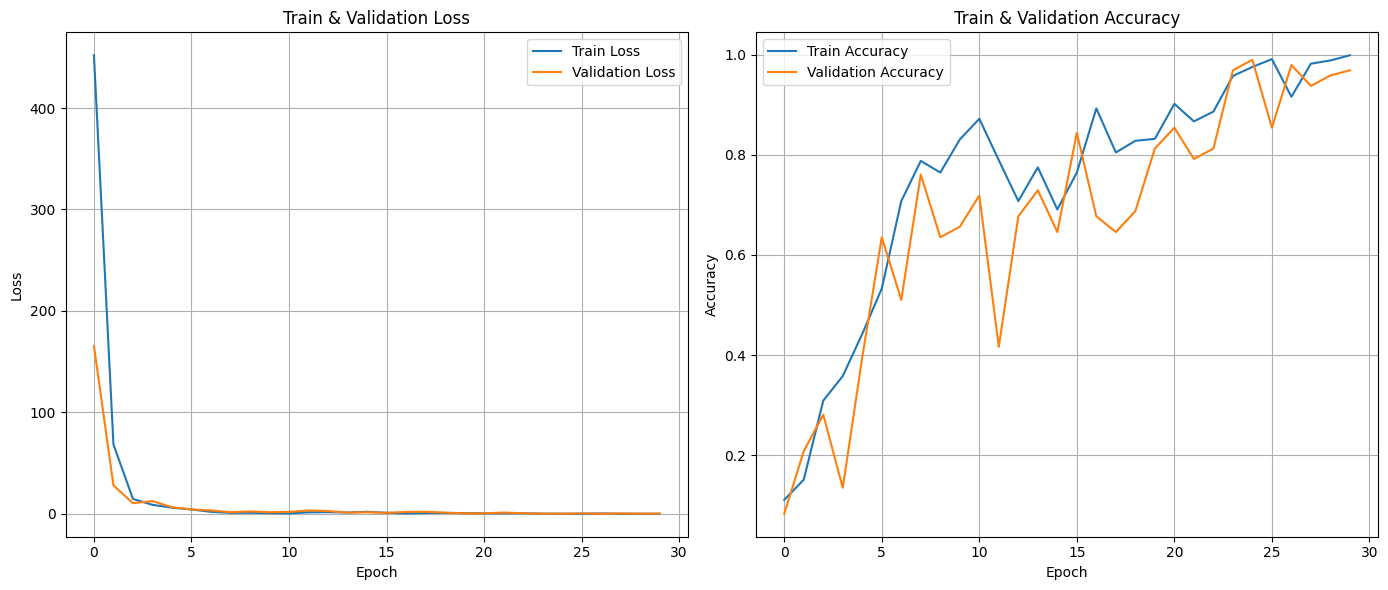

In [7]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Based on the above plots, the dataset is extremely divided, even one MLP with 3 linear layers can achieve 90% accuracy in Test set. Moreover, the accuracy has reached almost the 100%, which seems the model may be overfitted, so the total number of epochs and the complexity of the model should been reduced for better generalization. A lot of techniques like requlization, dropout, and hyperparameter tuning can be applied to reduce the model complexity and avoid the potential overfitting.

# Task 7 -Convolution Neural Networks

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)  # 64->32->16

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # (B,32,64,64)
        x = self.pool(x)              # (B,32,32,32)

        x = self.relu(self.conv2(x))  # (B,64,32,32)
        x = self.pool(x)              # (B,64,16,16)

        x = self.flatten(x)           # (B,64*16*16)
        x = self.relu(self.fc1(x))    # (B,128)
        x = self.fc2(x)               # (B,num_classes) logits
        return x

model = CNN(num_classes=num_classes)
X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # (N,3,64,64)
y_tensor = torch.tensor(y, dtype=torch.long)                        # (N,)

dataset = TensorDataset(X_tensor, y_tensor)

# Split
N = len(dataset)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader: # images are now (B, C, H, W), labels are (B,)
        optimizer.zero_grad()
        outputs = model(images)                  # logits (B,C)
        loss = criterion(outputs, labels)        # labels (B,) expects (B,) for class indices

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item() # labels are already class indices
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #  Validation
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader: # images are now (B, C, H, W), labels are (B,)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item() # labels are already class indices
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")

model.eval()
test_loss = 0.0
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader: # images are now (B, C, H, W), labels are (B,)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item() # labels are already class indices
        total += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct / total

print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

/tmp/ipython-input-631107262.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # (N,3,64,64)


Epoch [5/30] | Train Loss: 0.005, Train Acc: 1.000 | Val Loss: 0.143, Val Acc: 0.972
Epoch [10/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.180, Val Acc: 0.972
Epoch [15/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.168, Val Acc: 0.972
Epoch [20/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.170, Val Acc: 0.972
Epoch [25/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.168, Val Acc: 0.972
Epoch [30/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.166, Val Acc: 0.972

Test Loss: 0.075
Test Accuracy: 0.986


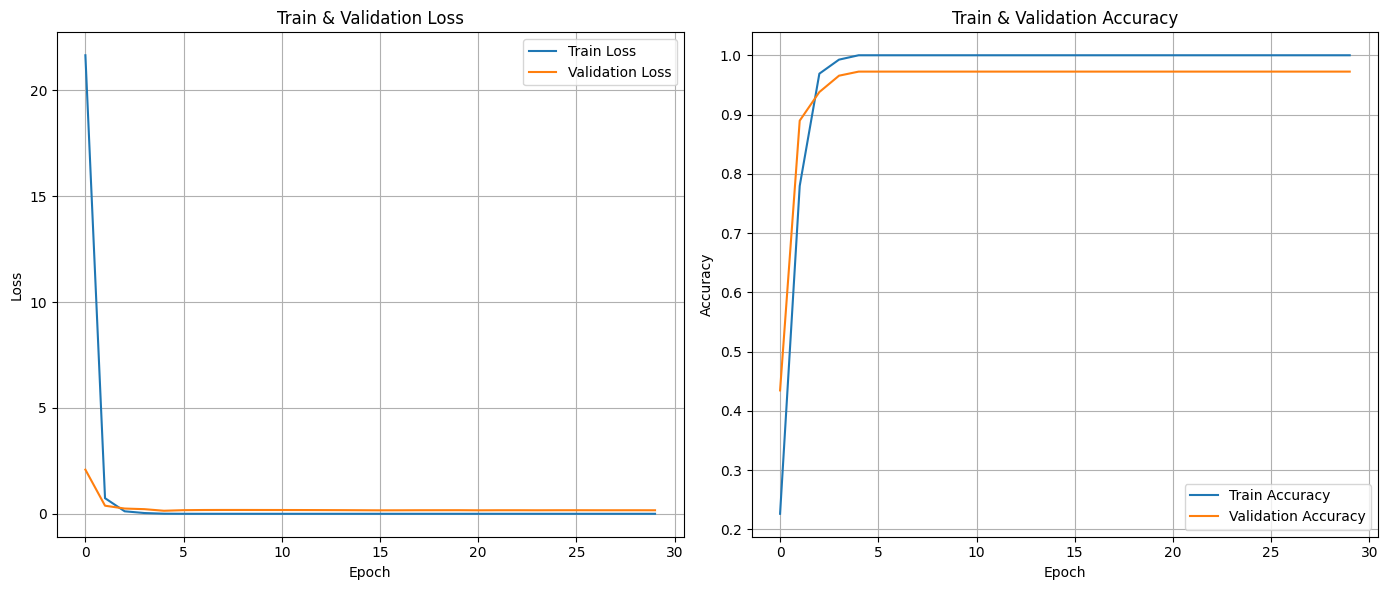

In [10]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Based on the above metrics in test set, the CNN architecture achieved better results than the MLP. The difference between their accuracies is extremely cloze, showing that both models reached high performance. In this case (CNN) the the model was overfitted, because the train loss reach 0.00 and the train accuracy reach almost perfect accuracy 100% even from the start of the epochs.

The CNN layers is more superior method than MLP, specifically in when data are images, becasue these models can extract characteristics from all the regions of the image. The CNN learns features in a hierarchical manner. Early layers capture simple patterns, while deeper layers combine these patterns into more complex representations. This structured feature composition allows the CNN to model relationships in the data more effectively than the MLP. The CNN exhibits a smaller gap between training and validation accuracy, indicating better generalization. The CNN maintains performance even when local patterns appear in different spatial locations within the input. This robustness is achieved through weight sharing and pooling operations, which reduce sensitivity to small variations in the input data.

# Task - 8

Strandard Scaling, Batch Normalization, Dropout

In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))

        x = self.flatten(x)
        x = self.dropout(self.relu(self.bn_fc1(self.fc1(x))))
        x = self.fc2(x)

        return x


In [12]:
X = X / 255.0   # scale to [0,1]

# ImageNet-style normalization (safe & standard)
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

X = (X - mean) / std

X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # (N,3,64,64)
y_tensor = torch.tensor(y, dtype=torch.long)                        # (N,)

dataset = TensorDataset(X_tensor, y_tensor)

# Split
N = len(dataset)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader: # images are now (B, C, H, W), labels are (B,)
        optimizer.zero_grad()
        outputs = model(images)                  # logits (B,C)
        loss = criterion(outputs, labels)        # labels (B,) expects (B,) for class indices

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item() # labels are already class indices
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    #  Validation
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader: # images are now (B, C, H, W), labels are (B,)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item() # labels are already class indices
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")

model.eval()
test_loss = 0.0
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader: # images are now (B, C, H, W), labels are (B,)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item() # labels are already class indices
        total += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct / total

print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

/tmp/ipython-input-1171096270.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X = (X - mean) / std
/tmp/ipython-input-1171096270.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # (N,3,64,64)


Epoch [5/30] | Train Loss: 0.004, Train Acc: 1.000 | Val Loss: 0.045, Val Acc: 0.979
Epoch [10/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.035, Val Acc: 0.979
Epoch [15/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.034, Val Acc: 0.993
Epoch [20/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.039, Val Acc: 0.979
Epoch [25/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.044, Val Acc: 0.979
Epoch [30/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.045, Val Acc: 0.993

Test Loss: 0.009
Test Accuracy: 1.000


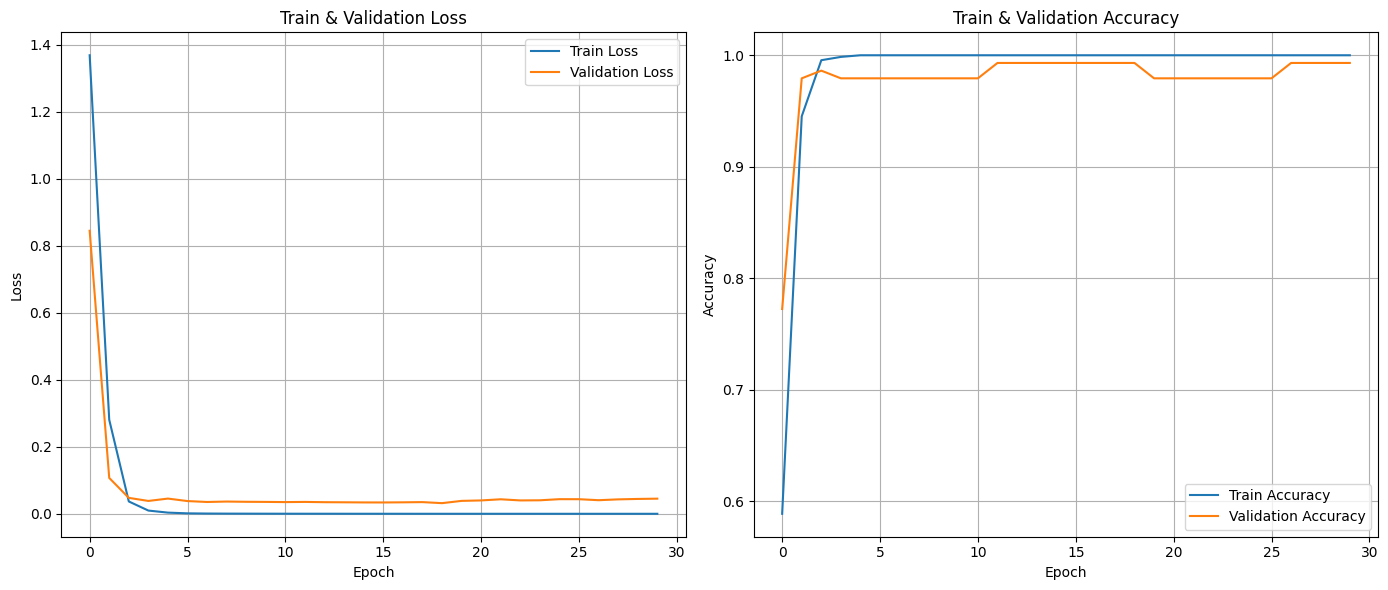

In [13]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


By applying the above metrics the model reached in test set 100% accuracy. Bellow images are from test set along with their actual label and the predicting label. The model reached higher accuracy and indentifies all the samples correctly.

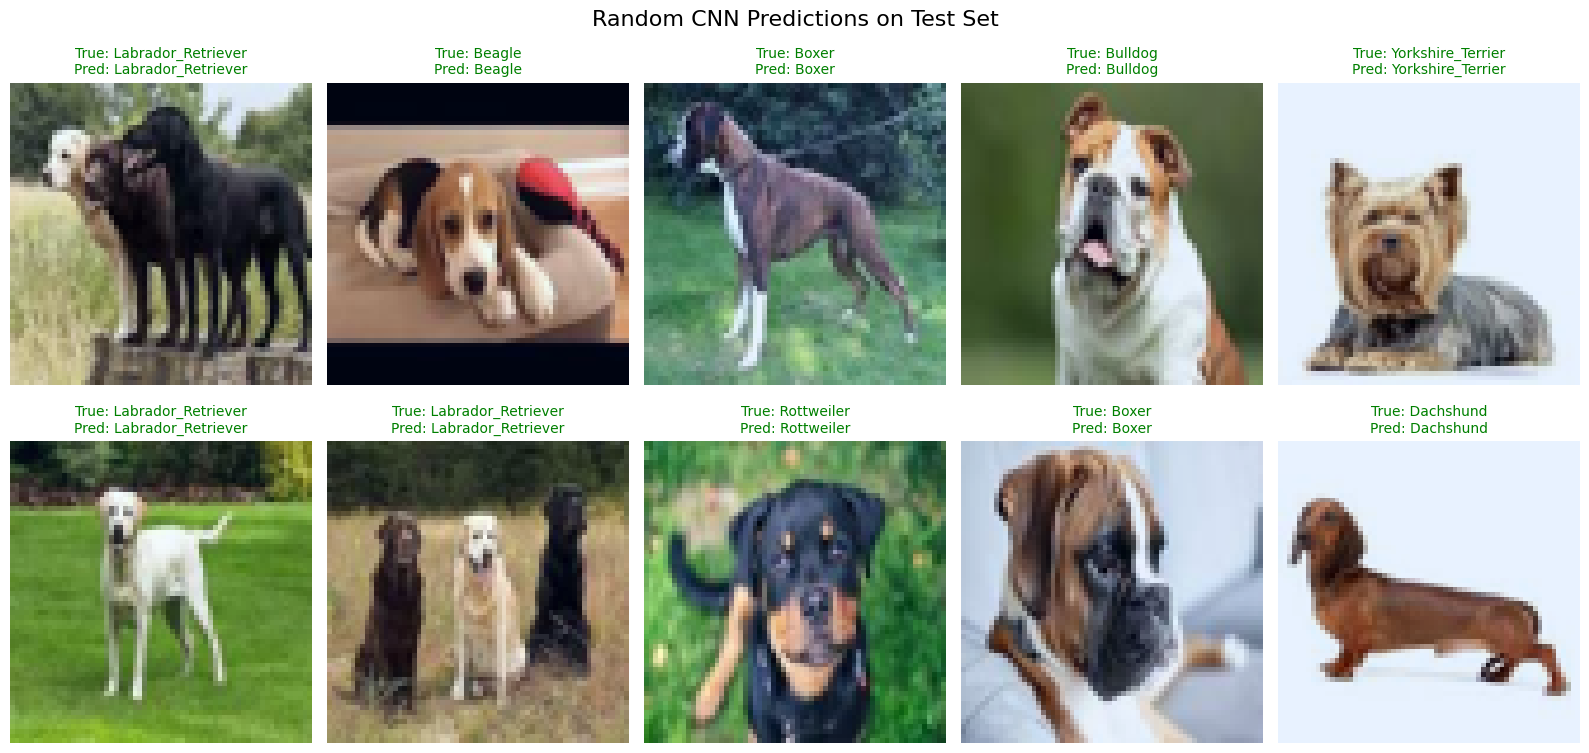

In [20]:
idx_to_class = {
    0: 'Beagle',
    1: 'Boxer',
    2: 'Bulldog',
    3: 'Dachshund',
    4: 'German_Shepherd',
    5: 'Golden_Retriever',
    6: 'Labrador_Retriever',
    7: 'Poodle',
    8: 'Rottweiler',
    9: 'Yorkshire_Terrier'
}

model.eval()
num_images = 10
images, labels = next(iter(test_loader))

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)


indices = random.sample(range(images.size(0)), num_images)

plt.figure(figsize=(16, 8))

for i, idx in enumerate(indices):
    img = images[idx].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # (C,H,W) → (H,W,C)

    img = img - img.min()
    img = img / img.max()

    true_label = idx_to_class[labels[idx].item()]
    pred_label = idx_to_class[preds[idx].item()]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

    color = "green" if labels[idx] == preds[idx] else "red"
    plt.title(
        f"True: {true_label}\nPred: {pred_label}",
        color=color,
        fontsize=10)

plt.suptitle("Random CNN Predictions on Test Set", fontsize=16)
plt.tight_layout()
plt.show()